<a href="https://colab.research.google.com/github/GabyDs/EjerciciosInteligenciaComputacional/blob/main/Lab2Ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiencia 1

Se tiene un dataset con información relacionada a un conjunto de transacciones realizadas por los
clientes de una compañía. Estas transacciones se corresponden a compras realizadas con tarjetas de
crédito.

Los datos se encuentran tabulados en un archivo del tipo “.csv”, por cuestiones de confidencialidad
(al tratar con datos reales) los mismos se encuentran transformados en las características principales.
Se disponen de más de 280.000 transacciones, de las cuales, menos del 0,2% corresponde a eventos
fraudulentos.

El dataset presenta la siguiente estructura:
* Time: número de segundos transcurridos entre esta transacción y la primera transacción en
el conjunto de datos.
* V1 a V28: características determinadas como relevantes, puede ser el resultado de una
reducción de dimensionalidad mediante PCA (Principal Component Analysis). Suele ser común
al compartir información con identidad de usuarios y funciones confidenciales.
* Amount: monto de la transacción.
* Class: categórica. “1” para transacción fraudulenta, “0” no fraudulenta.

Durante la experiencia, responder las siguientes cuestiones:
* ¿Qué estrategia conviene seguir al tratar problemas con clases muy desbalanceadas?
* Para este tipo de aplicación, ¿Qué clase conviene identificar con precisión?
* ¿Qué topología permite caracterizar clases con muchas observaciones disponibles?
* Para obtener resultados adecuados, ¿Es necesario utilizar toda la información disponible en
el dataset?
* Justifique el desempeño de la RNA lograda, ¿Qué métrica de desempeño es la idónea para el
problema?
* ¿Es determinante conocer el contexto de los datos/descriptores para obtener un buen
modelo?

## Set de datos: Analisis exploratorio

In [1]:
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1W52k-utI3hnST8RRnnmXI7szW_vbb1iv&confirm=t" -O creditcard.zip
!unzip -qq creditcard.zip

--2023-05-07 20:03:17--  https://drive.google.com/uc?export=download&id=1W52k-utI3hnST8RRnnmXI7szW_vbb1iv&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.202.100, 173.194.202.102, 173.194.202.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.202.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v62sstdgq1c2kv76871ju5mc07obg1dt/1683489750000/12225850433951268217/*/1W52k-utI3hnST8RRnnmXI7szW_vbb1iv?e=download&uuid=e2c5a008-7ead-4093-9718-d94800eb760b [following]
--2023-05-07 20:03:17--  https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v62sstdgq1c2kv76871ju5mc07obg1dt/1683489750000/12225850433951268217/*/1W52k-utI3hnST8RRnnmXI7szW_vbb1iv?e=download&uuid=e2c5a008-7ead-4093-9718-d94800eb760b
Resolving doc-0s-9c-docs.googleusercontent.com (doc-0s-9c-docs.googleusercontent.com)... 74.125.

In [2]:
import pandas as pd

dataset = pd.read_csv('./creditcard.csv')

In [3]:
dataset.shape

(284807, 31)

In [4]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Observamos la cantidad de muestras fraudulentas y no fraudulentas

data_fraude = dataset[dataset.Class == 1]
data_no_fraude = dataset[dataset.Class == 0]

print("Muestras fraudulentas: {}".format(len(data_fraude)))
print("Muestras no fraudulentas: {}".format(len(data_no_fraude)))

Muestras fraudulentas: 492
Muestras no fraudulentas: 284315


Se puede observar que el dataset esta super desbalanceado, por ende no podemos encarar la resolucion del problema como un problema tipico de clasificacion.

In [6]:
# Observamos lo anterior pero porcentualmente

porcentaje_fraude = (len(data_fraude) / len(data_no_fraude)) * 100

print("Porcentaje de muestras fraudulentas: {}%".format(round(porcentaje_fraude, 3)))

Porcentaje de muestras fraudulentas: 0.173%


In [7]:
# Observamos si hay alguna inperfeccion en los datos
dataset.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Como no se observa ningun tipo de error a simple vista, podemos empezar a separar los datos para entrenamiento y para test

El problema se va a encadar como clasificacion, pero se utilizara autoencoders, con el fin de poder detectar transacciones no fraudulentas de manera optima y en las fraudulentas obtener un error significativo que nos proporcione la informacion necesaria.

En el caso del modelo predictor de fraude crediticio, si las características de monto y de la clase correspondiente no están difusas, es importante conocer el contexto de los datos para comprender por qué estas características no están difusas y cómo pueden influir en la predicción del fraude. Por ejemplo, la comprensión del contexto puede ayudar a identificar patrones en el monto del préstamo y cómo estos patrones pueden estar relacionados con la probabilidad de fraude.

In [8]:
from sklearn.model_selection import train_test_split

# Separamos unicamente los datos que no son fraudulentos
train, test = train_test_split(data_no_fraude, test_size=0.3, random_state=0, shuffle=True)

In [9]:
print(train.shape)
print(test.shape)

(199020, 31)
(85295, 31)


In [10]:
# Observaciones por categoría (para entrenamiento)
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
train = train.values
test = test.values
validation = data_fraude.values

# Etiquetas, me quedo solamente con el vector de las clases
cat_train = train[:,30]
cat_test = test[:,30]
cat_validation = validation[:,30]

### Comparacion visual entre clases

<ipython-input-12-386740f390db>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


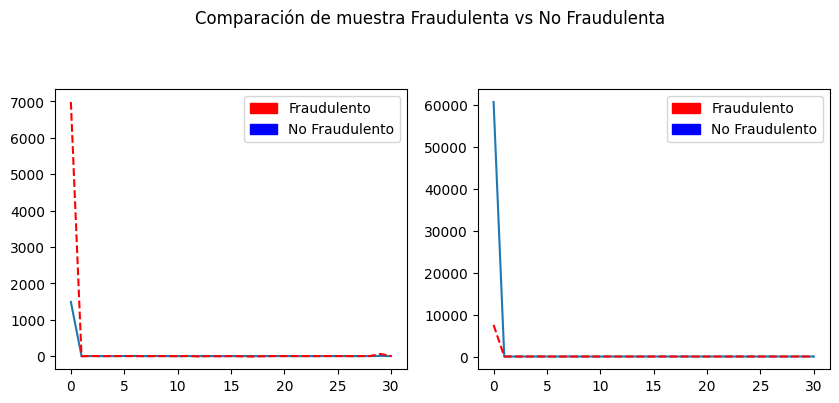

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Dibujar un dato fraudulento y uno no fraudulento

muestra = 3

no_fraude1 = train[muestra]
fraude1 = validation[muestra]

no_fraude2 = train[2 * muestra]
fraude2 = validation[2 * muestra]

red = mpatches.Patch(color='red', label='Fraudulento')
blue = mpatches.Patch(color='blue', label='No Fraudulento')

plt.figure(figsize=(10,8))
plt.grid()

plt.subplot(2,2,1)
plt.plot(np.arange(31), no_fraude1)
plt.plot(np.arange(31), fraude1, 'r--')
plt.legend(handles=[red, blue])

plt.subplot(2,2,2)
plt.plot(np.arange(31), no_fraude2)
plt.plot(np.arange(31), fraude2, 'r--')
plt.legend(handles=[red, blue])


plt.suptitle('Comparación de muestra Fraudulenta vs No Fraudulenta')
plt.show()

### Preprocesamiento (normalización de los datos)

In [13]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

train_norm = min_max_scaler.fit_transform(train)

print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(train), np.max(train)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(train_norm), np.max(train_norm)))

test_norm = min_max_scaler.fit_transform(test)
validation_norm = min_max_scaler.fit_transform(validation)

Mínimo y máximo originales: -113.7, 172792.0
Mínimo y máximo normalización: 0.0, 1.0


#### Observamos nuevamente la grafica anterior

<ipython-input-14-28a91799a664>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


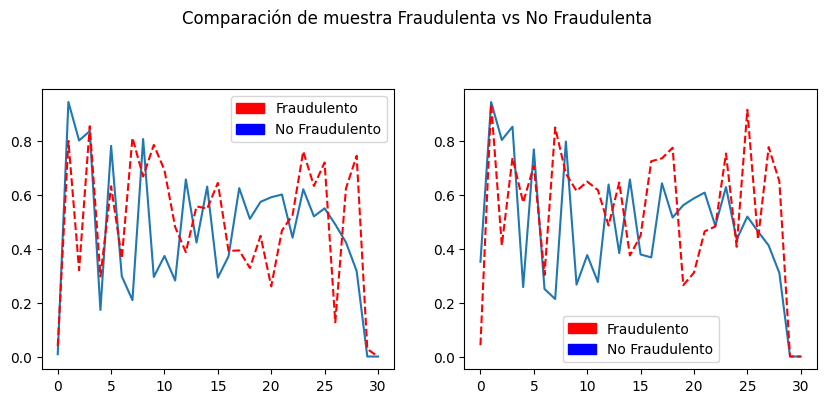

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Dibujar un dato fraudulento y uno no fraudulento

muestra = 3

no_fraude1 = train_norm[muestra]
fraude1 = validation_norm[muestra]

no_fraude2 = train_norm[2 * muestra]
fraude2 = validation_norm[2 * muestra]

red = mpatches.Patch(color='red', label='Fraudulento')
blue = mpatches.Patch(color='blue', label='No Fraudulento')

plt.figure(figsize=(10,8))
plt.grid()

plt.subplot(2,2,1)
plt.plot(np.arange(31), no_fraude1)
plt.plot(np.arange(31), fraude1, 'r--')
plt.legend(handles=[red, blue])

plt.subplot(2,2,2)
plt.plot(np.arange(31), no_fraude2)
plt.plot(np.arange(31), fraude2, 'r--')
plt.legend(handles=[red, blue])


plt.suptitle('Comparación de muestra Fraudulenta vs No Fraudulenta')
plt.show()

Ahora se puede apreciar mejor la diferencia entre las clases

## Creacion del Autoencoder

In [15]:
from tensorflow.keras.models import Model           # Para construir el modelo con las capas especificadas
from tensorflow.keras.layers import Input, Dense    # Tipos de capas a utilizar
import tensorflow as tf

np.random.seed(123) # Para replicar resultados
tf.random.set_seed(111)

dim_entrada = train_norm.shape[1]

# Capa de entrada
entrada = Input(shape=(dim_entrada,))

# Encoder
encoder = Dense(128, activation='relu')(entrada)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)

encoder = Dense(8, activation='relu')(encoder)

# Decoder
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)

decoder = Dense(dim_entrada, activation='sigmoid')(decoder)

# Autoencoder = entrada + decoder (que ya contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31)]              0         
                                                                 
 dense (Dense)               (None, 128)               4096      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 64)                1088  

El uso de una topología profunda y ancha permite que la RNA tenga una capacidad de aprendizaje más amplia, lo que le permite detectar patrones complejos y relaciones no lineales en los datos. Además, esto ayuda a reducir la posibilidad de sobreajuste, ya que la red tiene una mayor capacidad para generalizar los patrones que encuentra en los datos

### Optimizacion y entrenamiento

In [16]:
train_norm.shape

(199020, 31)

In [17]:
autoencoder.compile(optimizer='adam', loss='mae')       # error absoluto medio (*Mean Absolute Error*, MAE), función de pérdida
historia = autoencoder.fit(train_norm, train_norm,    # Notar que para entrenar, la entrada y salida son similares. Se evalúa la reconstrucción.
          epochs=20, 
          batch_size=512,
          validation_data=(test_norm, test_norm),
          shuffle=True)

Epoch 1/20
389/389 [==============================] - 7s 10ms/step - loss: 0.0420 - val_loss: 0.0885
Epoch 2/20
389/389 [==============================] - 3s 9ms/step - loss: 0.0249 - val_loss: 0.0859
Epoch 3/20
389/389 [==============================] - 5s 12ms/step - loss: 0.0239 - val_loss: 0.0853
Epoch 4/20
389/389 [==============================] - 3s 9ms/step - loss: 0.0231 - val_loss: 0.0863
Epoch 5/20
389/389 [==============================] - 4s 9ms/step - loss: 0.0226 - val_loss: 0.0846
Epoch 6/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0222 - val_loss: 0.0846
Epoch 7/20
389/389 [==============================] - 4s 10ms/step - loss: 0.0221 - val_loss: 0.0854
Epoch 8/20
389/389 [==============================] - 4s 9ms/step - loss: 0.0219 - val_loss: 0.0846
Epoch 9/20
389/389 [==============================] - 3s 9ms/step - loss: 0.0215 - val_loss: 0.0829
Epoch 10/20
389/389 [==============================] - 5s 12ms/step - loss: 0.0207 - val_loss: 0

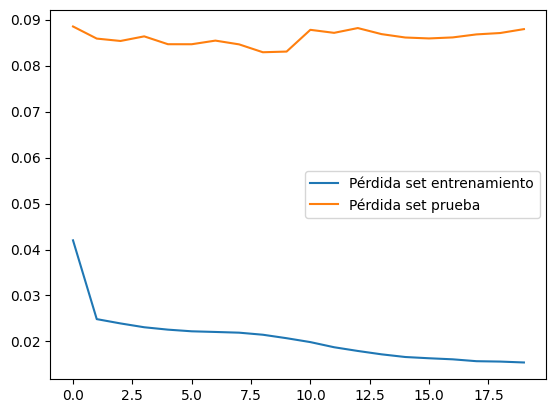

In [18]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

### Clasificacion

In [19]:
# ¿Qué tan bien reconstruye un dato "No Fraudulento" y uno Fraudulento?
rec_no_fraude = autoencoder(test_norm).numpy()
rec_fraude = autoencoder(validation_norm).numpy()

Text(0.5, 1.0, 'Clase Fraudulenta')

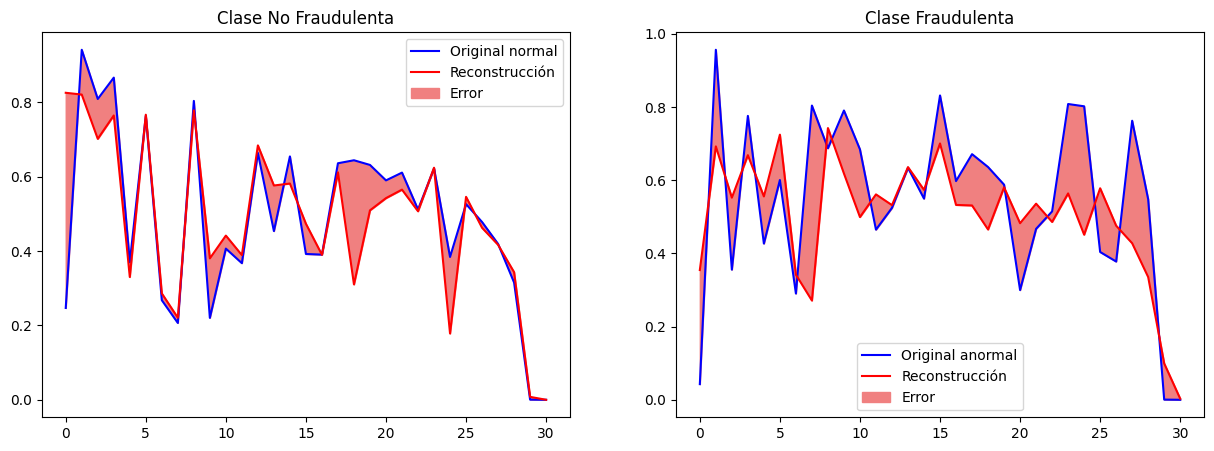

In [20]:
dato = 10

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_norm[dato],'b')
plt.plot(rec_no_fraude[dato],'r')
plt.fill_between(np.arange(31), rec_no_fraude[dato], train_norm[dato], color='lightcoral')    # Este método rellena el área de diferencia entre funciones. El error en este caso.
plt.legend(labels=["Original normal", "Reconstrucción", "Error"])
plt.title("Clase No Fraudulenta")

plt.subplot(1,2,2)
plt.plot(validation_norm[dato],'b')
plt.plot(rec_fraude[dato],'r')
plt.fill_between(np.arange(31), rec_fraude[dato], validation_norm[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstrucción", "Error"])
plt.title("Clase Fraudulenta")

Se observa a simple vista que el error es mayor a la hora de reconstruir una clase anormal. Con esta diferencia, se pueden construir un histograma y determinar el umbral óptimo para la separación de las clases.

En este caso, el MAE puede ser una métrica adecuada para evaluar el rendimiento del modelo, ya que mide la diferencia media entre la entrada y la salida del autoencoder. Cuanto mayor sea el MAE, mayor será el error de reconstrucción y, por lo tanto, mayor será la probabilidad de que el punto de datos sea anómalo.

Sin embargo, es importante tener en cuenta que el MAE no es la única métrica que se debe considerar al evaluar el modelo. Otras métricas, como la precisión y el recall, también son importantes para evaluar el rendimiento del modelo en la detección de anomalías. Además, se recomienda utilizar diferentes métricas y probar diferentes umbrales de detección para determinar la métrica más adecuada para su problema específico.

In [21]:
# Distribuciones de los errores de construcción
# para cada categoría

rec_no_fraude = autoencoder.predict(test_norm)
rec_fraude = autoencoder.predict(validation_norm)

loss_no_fraude = tf.keras.losses.mae(rec_no_fraude, test_norm)
loss_fraude = tf.keras.losses.mae(rec_fraude, validation_norm)

16/16 [==============================] - 0s 2ms/step


In [22]:
# Cálculo del umbral óptimo para la separación
umbral = np.mean(loss_no_fraude) + 3*np.std(loss_no_fraude)       # Media de la pérdida más el desvío estándar en este caso.
print("Umbral: ", umbral)

# Es decir, establecemos un valor de umbral tal que el dato anómalo debe tener tres desviación estándar por encima de la media.

Umbral:  0.10932418692661089


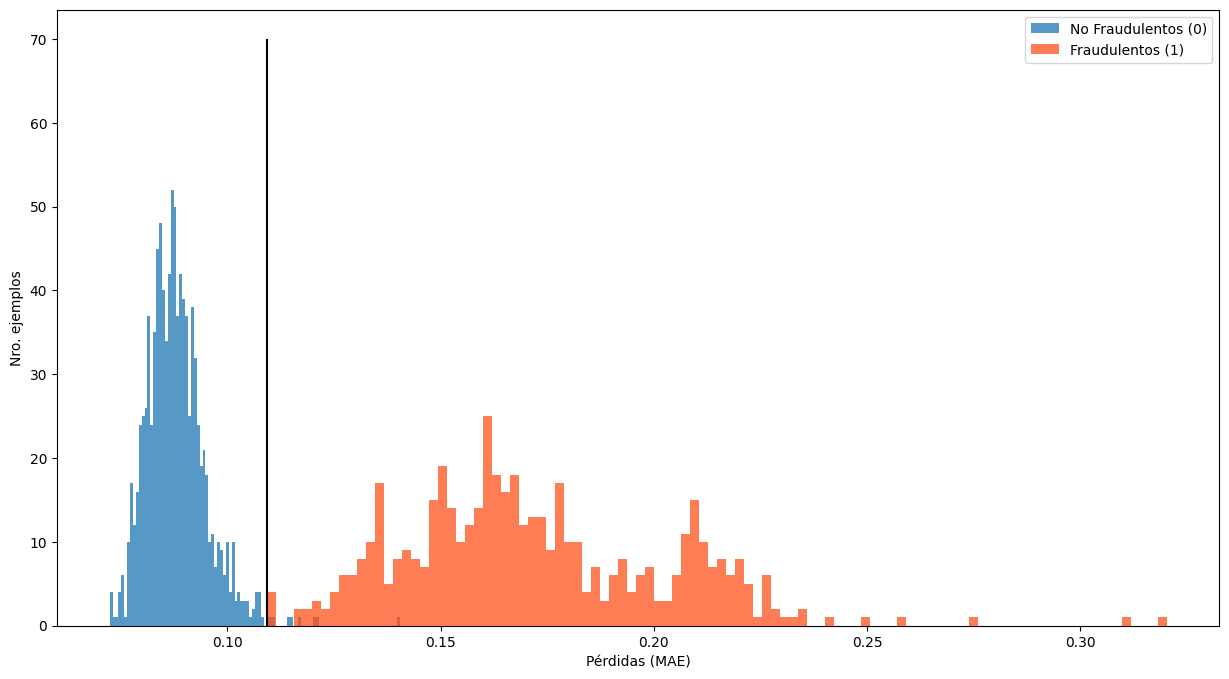

In [23]:
# Gráficas de las distribuciones por categorías, más umbral de separación

plt.figure(figsize=(15,8))

plt.hist(loss_no_fraude[None,:1000], bins=100, alpha=0.75, label='No Fraudulentos (0)')
plt.hist(loss_fraude[None,:], bins=100, alpha=0.75, color='#ff521b', label='Fraudulentos (1)')

plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(umbral,0,70,'k')

In [24]:
# Función ejemplo de inferencia en producción utilizando el modelo. Asumimos que llegan normalizados los datos.
def predecir(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

# Cálculo de las métricas recién vistas.
def calcular_sensitividad(prediccion, titulo):
  TP = np.count_nonzero(~prediccion)
  FN = np.count_nonzero(prediccion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.2f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
  TN = np.count_nonzero(prediccion)
  FP = np.count_nonzero(~prediccion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.2f}%'.format(esp))
  return esp

In [25]:
# Predicciones
pred_no_fraude = predecir(autoencoder, test_norm, umbral)
pred_fraude = predecir(autoencoder, validation_norm, umbral)

# Pred_no_fraude: Especificidad
esp_no_fraude = calcular_especificidad(pred_no_fraude,'Especificidad (cat. 0, No Fraudulentas)')

# Pred_fraude: Sensitividad
sen_fraude = calcular_sensitividad(pred_fraude,'Sensitividad (cat. 1, Fraudulentas)')



Especificidad (cat. 0, No Fraudulentas): 99.08%
Sensitividad (cat. 1, Fraudulentas): 100.00%


### Metricas usuales

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

def metricas_generales(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [27]:
# Para procesar todas las entradas en dataset de test
datos_validation = validation_norm[:,:31]                         # Agarro todo desde la columna uno en adelante, saco la categoría
datos_validation = min_max_scaler.transform(datos_validation)   # Escalado usado en preprocesamiento
cat_validation_binario = np.array([i==0 for i in cat_validation])   # Mapeo de cateorías, 1 es True y el resto es False (anómalas)


predicciones = predecir(autoencoder, datos_validation, umbral)
metricas_generales(predicciones, cat_validation_binario)

Accuracy = 1.0
Precision = 0.0
Recall = 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print("Classification Report: \n", classification_report(cat_validation_binario, predicciones))

Classification Report: 
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       492

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492

